## Modeling - Citation Prediction

In [1]:
# basic
import sys
import os
import json
import pdb
import ast
import time
import requests
from tqdm import tqdm
from collections import Counter, defaultdict, namedtuple

# debug
import pdb
from loguru import logger

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GMM

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from xgboost.sklearn import XGBRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# from warnings import filterwarnings
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.bool` is a deprecated alias')
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.int` is a deprecated alias' )
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.object` is a deprecated alias')


# custom
from utils import *

SEED = 0

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gautamchoudhary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [2]:
%%time
YEAR = 2017

works = pd.read_pickle(f'./data/{YEAR}/works.{YEAR}.v2.pkl').set_index('id')
authors = pd.read_pickle(f'./data/{YEAR}/authors.{YEAR}.v2.pkl').set_index('id')
venues = pd.read_pickle(f'./data/{YEAR}/venues.{YEAR}.v2.pkl').set_index('id')
insts = pd.read_pickle(f'./data/{YEAR}/insts.{YEAR}.v2.pkl').set_index('id')

CPU times: user 4.44 s, sys: 3.63 s, total: 8.07 s
Wall time: 9.58 s


In [3]:
%%time
works, authors, venues, insts = preprocess_data(works, YEAR, 2022, authors, venues, insts)

CPU times: user 1.41 s, sys: 339 ms, total: 1.75 s
Wall time: 1.88 s


In [4]:
# Train Test Split: based on `works`
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(works)),
                                           test_size=TEST_SIZE, random_state=SEED)

### Feature Extraction

In [5]:
df = get_features(works, authors, venues, insts, YEAR, N_CLASSES=2, seed=SEED)
df.shape

(135369, 15)

count    135369.000000
mean          2.563881
std           8.177346
min           0.000000
50%           1.000000
90%           6.000000
91%           6.000000
92%           7.000000
93%           7.000000
94%           8.000000
95%          10.000000
96%          11.000000
97%          14.000000
98%          18.000000
99%          29.000000
max         662.000000
Name: y_reg, dtype: float64


<AxesSubplot:xlabel='y_reg', ylabel='Count'>

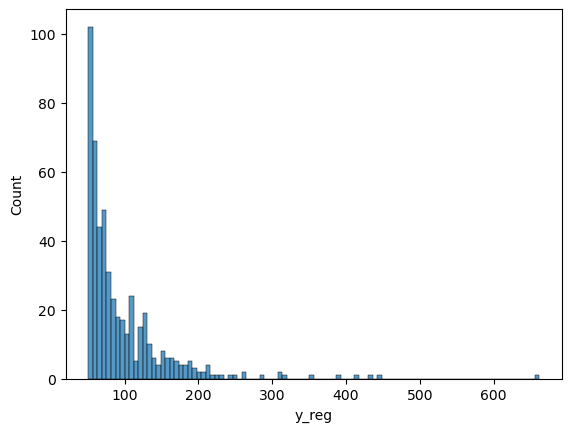

In [6]:
# check distribution of citations - target variable
temp = df['y_reg']
print(temp.describe(percentiles=[i/100 for i in range(90, 100, 1)]))
sns.histplot(temp[temp>50], bins=100)

## Concept Features

In [41]:
import networkx as nx
from collections import Counter

# EDGES = [
#     ('A', 'B'),
#     ('B', 'C'),
#     ('A', 'C'),
#     ('C', 'D'),
#     ('A', 'B')
# ]

temp = works.iloc[train_index]['concepts']
edge_list = []
for work_id, concepts in temp.items():
    for concept_id, score in concepts:
        edge_list.append((work_id, concept_id, np.float(score)))

print (len(edge_list), edge_list[:5])



g = nx.Graph((x, y, {'weight': v}) for x, y, v in edge_list)
# print(*g.edges(data=True), sep='\n')

/var/folders/xw/2zvdx8_94cgd_c7qxhnvgq9c0000gn/T/ipykernel_44542/69673674.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge_list.append((work_id, concept_id, np.float(score)))


536887 [('W2771456258', 'C41008148', 0.7595465), ('W2771456258', 'C153083717', 0.72854745), ('W2771456258', 'C124101348', 0.6389492), ('W2771456258', 'C2776214188', 0.6055116), ('W2771456258', 'C26517878', 0.56039643)]


In [ ]:
# with open('./node2vec-master/graph/input_concepts_graph.txt', 'w') as f:
#     f.write('\n'.join(edge_list))

In [ ]:
import networkx as nx
from node2vec import Node2Vec

# Create a graph
# graph = nx.fast_gnp_random_graph(n=100, p=0.5)

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(g, dimensions=8, walk_length=10, num_walks=10, workers=8)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=4, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# # Save embeddings for later use
# model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# # Save model for later use
# model.save(EMBEDDING_MODEL_FILENAME)

# # Embed edges using Hadamard method
# from node2vec.edges import HadamardEmbedder

# edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# # Look for embeddings on the fly - here we pass normal tuples
# edges_embs[('1', '2')]
# ''' OUTPUT
# array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
#        ... ... ....
#        ..................................................................],
#       dtype=float32)
# '''

# # Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
# edges_kv = edges_embs.as_keyed_vectors()

# # Look for most similar edges - this time tuples must be sorted and as str
# edges_kv.most_similar(str(('1', '2')))

# # Save embeddings for later use
# edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

Computing transition probabilities:   6%|██▏                                   | 7288/126829 [04:01<1:21:05, 24.57it/s]/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/node2vec/node2vec.py:125: RuntimeWarning: invalid value encountered in true_divide
  source] = unnormalized_weights / unnormalized_weights.sum()
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/node2vec/node2vec.py:129: RuntimeWarning: invalid value encountered in true_divide
  d_graph[current_node][self.FIRST_TRAVEL_KEY] = unnormalized_weights / unnormalized_weights.sum()
Computing transition probabilities:  68%|█████████████████████████▎           | 86846/126829 [2:09:55<40:49, 16.33it/s]

In [1]:
my_dict = dict({})
for idx, key in enumerate(model.wv.key_to_index):
    my_dict[key] = model.wv[key]
    # Or my_dict[key] = model.wv.get_vector(key)
    # Or my_dict[key] = model.wv.word_vec(key, use_norm=False)

NameError: name 'model' is not defined

In [14]:
len(my_dict)

100

## Textual Features

#### Sentence Transformers 

In [7]:
# ref (tutorial): https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
# ref (docs): https://www.sbert.net/examples/training/distillation/README.html
# ref (for pretrained models): https://www.sbert.net/docs/pretrained_models.html
# ref (dim reduction): https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/distillation/dimensionality_reduction.py

# `$ conda install -c conda-forge sentence-transformers`
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
# ref: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentences = ["I ate dinner.", 
       "We had a three-course meal.", 
       "Brad came to dinner with us.",
       "He loves fish tacos.",
       "In the end, we all felt like we ate too much.",
       "We all agreed; it was a magnificent evening."]
sentence_embeddings = model.encode(sentences)

print ('dimensions of embedding: ', sentence_embeddings.shape[1])
#print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
#print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dimensions of embedding:  384


In [26]:
%%time
embeds = model.encode(works['abstract'].tolist()[:10000])
print (embeds.shape)

(10000, 384)
CPU times: user 25min 3s, sys: 8min 50s, total: 33min 54s
Wall time: 4min 50s


In [20]:
temp = works[['abstract']][:1000]
temp.shape

(1000, 1)

In [25]:
%%time
temp['embed'] = temp['abstract'].map(lambda x: model.encode([x])[0])

CPU times: user 3min 8s, sys: 1min 24s, total: 4min 32s
Wall time: 38.9 s


#### Doc2Vec

In [77]:
# train doc2vec
docs = works.iloc[train_index]['abstract'].tolist()[:1000]
train_doc2vec(docs, dims=16, saved_model_name='d2v.abstract.model')


Tagging: 0it [00:00, ?it/s]
Tagging: 205it [00:00, 2046.26it/s]
Tagging: 417it [00:00, 2086.89it/s]
Tagging: 638it [00:00, 2142.69it/s]
Tagging: 1000it [00:00, 2119.65it/s][A

Training: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 230.92it/s]

Model Saved: d2v.abstract.model


In [78]:
# infer doc2vec
abs_feats = infer_doc2vec(works, 'abstract', df.index[:1000], dims=16, saved_model='d2v.abstract.model')


Inferencing: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 627.31it/s]


In [79]:
abs_feats.shape

(1000, 16)

In [85]:
combined_df = pd.concat([df, abs_feats]).shape

(136369, 47)

In [72]:
model= Doc2Vec.load(saved_model)
model.infer_vector(word_tokenize(works.loc['W2964260135', 'abstract'].lower()))

array([-0.01438257, -0.02732935, -0.02846311,  0.00823997,  0.02541846,
        0.0278702 ,  0.02188501,  0.00544634,  0.02018293, -0.0026605 ,
       -0.0178687 , -0.01131115,  0.01179136, -0.02247644,  0.02942068,
        0.01227852], dtype=float32)

In [69]:
abs_feats

,abs_0,abs_1,abs_2,abs_3,abs_4,abs_5,abs_6,abs_7,abs_8,abs_9,abs_10,abs_11,abs_12,abs_13,abs_14,abs_15
id,,,,,,,,,,,,,,,,
W2555618208,-0.031209,-0.013547,-0.007729,-0.005980,-0.026215,0.028280,0.022289,0.015979,-0.027817,-0.014571,0.018843,-0.006797,0.025485,-0.000516,0.010233,0.019156
W2557641257,-0.027458,-0.021472,0.008528,-0.027202,-0.012704,0.030775,-0.010573,-0.008720,-0.029577,-0.018689,0.007815,0.028343,0.012058,-0.006893,0.010031,-0.004055
W2963709863,-0.029792,-0.023372,0.012738,0.030597,0.028282,0.029465,-0.005610,0.007742,-0.001815,0.010166,0.015990,-0.030223,0.026768,-0.018059,-0.002249,-0.028647
W2594519801,-0.006590,0.000413,0.002018,0.003888,-0.005115,-0.008804,-0.029865,-0.025737,-0.022867,0.027330,-0.006566,-0.026142,0.019250,0.024849,0.007187,-0.011878
W2561715562,0.026548,-0.017629,0.025802,-0.019822,0.025197,0.027862,0.014930,-0.019636,-0.006094,0.019028,0.029887,-0.022509,-0.013593,-0.030331,-0.029080,0.022159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2787667267,0.014699,-0.020097,0.027668,-0.024690,-0.007483,-0.014791,-0.010474,0.029818,0.020939,0.030733,-0.010385,0.000579,0.019351,-0.011458,-0.018720,-0.015985
W2962741298,-0.019752,0.030724,0.006428,-0.031127,-0.013054,-0.004673,0.029530,-0.015712,-0.030850,0.010215,0.005554,0.017435,0.017984,0.014597,-0.030878,-0.017687
W2964260135,-0.014383,-0.027329,-0.028463,0.008240,0.025418,0.027870,0.021885,0.005446,0.020183,-0.002661,-0.017869,-0.011311,0.011791,-0.022476,0.029421,0.012279


In [60]:
df_new.head()

,no_of_authors,no_of_referenced_works,open_access_is_oa,publication_month,author_prominency,authors_mean_citations,authors_mean_works,venue_citations,venue_works,venue_significance,...,abs_6,abs_7,abs_8,abs_9,abs_10,abs_11,abs_12,abs_13,abs_14,abs_15
id,,,,,,,,,,,,,,,,,,,,,
W2555618208,4,18,True,7,1,165.250000,15.250000,270395,3422,79.016657,...,0.022289,0.015979,-0.027817,-0.014571,0.018843,-0.006797,0.025485,-0.000516,0.010233,0.019156
W2557641257,4,24,True,7,1,711.000000,36.250000,270395,3422,79.016657,...,-0.010573,-0.008720,-0.029577,-0.018689,0.007815,0.028343,0.012058,-0.006893,0.010031,-0.004055
W2963709863,6,20,True,7,1,522.166667,10.666667,270395,3422,79.016657,...,-0.005610,0.007742,-0.001815,0.010166,0.015990,-0.030223,0.026768,-0.018059,-0.002249,-0.028647
W2594519801,6,71,True,7,1,881.000000,13.833333,270395,3422,79.016657,...,-0.029865,-0.025737,-0.022867,0.027330,-0.006566,-0.026142,0.019250,0.024849,0.007187,-0.011878
W2561715562,6,25,True,7,1,5601.666667,57.333333,270395,3422,79.016657,...,0.014930,-0.019636,-0.006094,0.019028,0.029887,-0.022509,-0.013593,-0.030331,-0.029080,0.022159


### GMM - unsupervised clustering

In [7]:
# ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
# ref: https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

x = df['y_reg'].to_numpy().reshape(-1, 1)
n_components = np.arange(1, 11)
models = [GMM(n, covariance_type='full', random_state=SEED).fit(x)
          for n in tqdm(n_components)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]


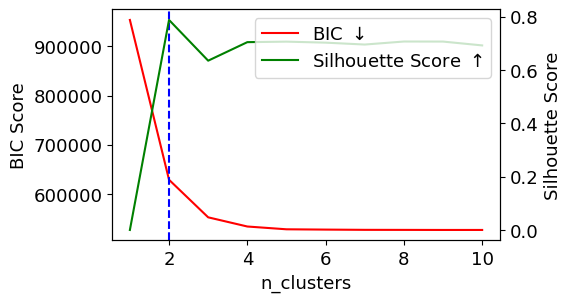

In [10]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(ncols=1, figsize=(5,3))

# bic score
ax.plot(n_components, [m.bic(x) for m in models], 'r-', label=r'BIC $\downarrow$')
ax.set_xlabel('n_clusters')
ax.set_ylabel('BIC Score')

# silhouette score
ax1 = ax.twinx()
s = [0] + [metrics.silhouette_score(x, m.predict(x), metric='euclidean', sample_size=1000) for m in models[1:]]
ax1.plot(n_components, s, 'g-', label=r'Silhouette Score $\uparrow$')
ax1.set_xlabel('n_clusters')
ax1.set_ylabel('Silhouette Score')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

# optimal cluster line
ax.axvline(2, color = 'b', linestyle='--')

plt.savefig('bic-sil-score.png', dpi=350, bbox_inches='tight')
plt.show()

In [19]:
# optimal clusters, n=2
model = GMM(n_components=2, covariance_type='full', random_state=SEED)
model.fit(x)
y = model.predict(x)

y0 = pd.Series(x.ravel())[y==0]
y1 = pd.Series(x.ravel())[y==1]
print (f'cluster 0 citations: [{y0.min()}, {y0.max()}], #samples={len(y0)} ({len(y0)/len(y)})')
print (f'cluster 1 citations: [{y1.min()}, {y1.max()}], #samples={len(y1)} ({len(y1)/len(y)})')

cluster 0 citations: [0, 5], #samples=121307 (0.8961209730440499)
cluster 1 citations: [6, 662], #samples=14062 (0.10387902695595003)
